In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch import optim
from torch.autograd import Variable

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

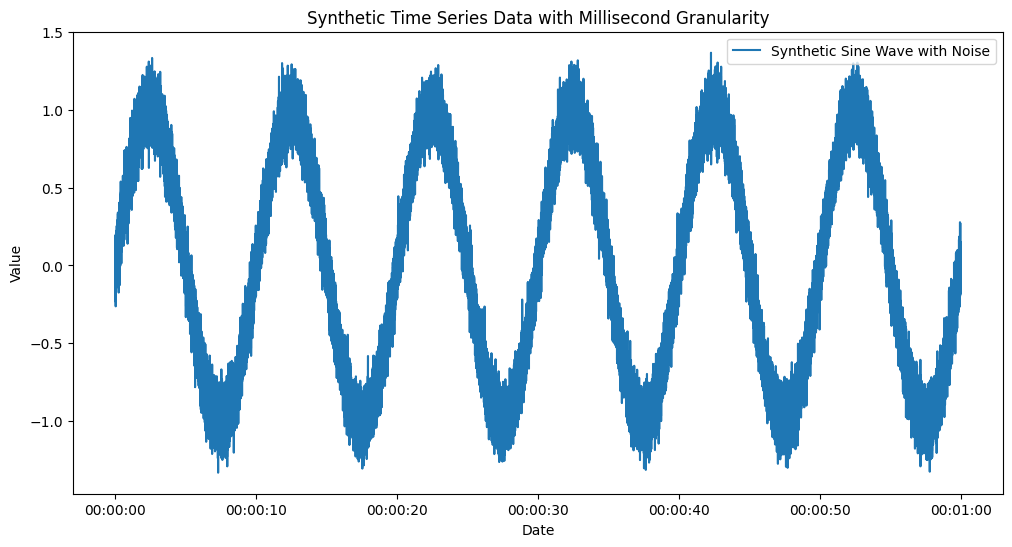

In [3]:
# Load the synthetic dataset from the CSV file
df = pd.read_csv('synthetic_data\synthetic_time_series_train.csv',
                 parse_dates=['Date'], index_col='Date')

# Plot the synthetic time series
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Value'], label='Synthetic Sine Wave with Noise')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Synthetic Time Series Data with Millisecond Granularity')
plt.legend()
plt.show()

In [4]:
# Normalize the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df['Value'].values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, input_window, output_window):
    xs, ys = [], []
    for i in range(len(data) - input_window - output_window + 1):
        x = data[i:i+input_window]
        y = data[i+input_window:i+input_window+output_window]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


input_window = 28
output_window = 1

X, y = create_sequences(scaled_values, input_window, output_window)
print(f"Input shape: {X.shape}, Output shape: {y.shape}")

# Split into training and testing sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

Input shape: (59972, 28, 1), Output shape: (59972, 1, 1)


In [5]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create PyTorch dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # Convolutional layer 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        # Convolutional layer 2
        self.conv2 = nn.Sequential(
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2)
        )

        self.out = nn.Linear(64 * 7, output_window)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # flatten the output of conv2 to (batch_size, 64 * 6 * 6)
        x = x.view(x.size(0), -1)
        output = self.out(x)
        return output, x    # return x for visualization

In [7]:
cnn = CNN()
print(cnn)
loss_func = nn.MSELoss()
print(loss_func)
optimizer = optim.Adam(cnn.parameters(), lr=0.001)
print(optimizer)

CNN(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=448, out_features=1, bias=True)
)
MSELoss()
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [8]:
num_epochs = 50

# Function to calculate RMSE
def calculate_rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))

# Lists to store loss and RMSE
train_rmse_list = []
val_rmse_list = []

# Training loop
for epoch in range(num_epochs):
    cnn.train()
    train_losses = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        X_batch = X_batch.transpose(1, 2).contiguous()
        outputs = cnn(X_batch)[0]
        y_batch = y_batch.squeeze(-1)
        loss = loss_func(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    # Calculate average training loss
    train_loss = np.mean(train_losses)

    # Calculate training RMSE
    train_rmse = calculate_rmse(
        outputs.detach().cpu().numpy(), y_batch.detach().cpu().numpy())
    train_rmse_list.append(train_rmse)

    # Print loss every 10 epochs
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [2/50], Loss: 0.0009
Epoch [4/50], Loss: 0.0018
Epoch [6/50], Loss: 0.0023
Epoch [8/50], Loss: 0.0019
Epoch [10/50], Loss: 0.0016
Epoch [12/50], Loss: 0.0015
Epoch [14/50], Loss: 0.0007
Epoch [16/50], Loss: 0.0016
Epoch [18/50], Loss: 0.0011
Epoch [20/50], Loss: 0.0011
Epoch [22/50], Loss: 0.0015
Epoch [24/50], Loss: 0.0027
Epoch [26/50], Loss: 0.0015
Epoch [28/50], Loss: 0.0012
Epoch [30/50], Loss: 0.0029
Epoch [32/50], Loss: 0.0022
Epoch [34/50], Loss: 0.0006
Epoch [36/50], Loss: 0.0009
Epoch [38/50], Loss: 0.0013
Epoch [40/50], Loss: 0.0010
Epoch [42/50], Loss: 0.0015
Epoch [44/50], Loss: 0.0018
Epoch [46/50], Loss: 0.0016
Epoch [48/50], Loss: 0.0016


11994
actuals size:  (11994, 5, 1)
Test RMSE: 0.1089


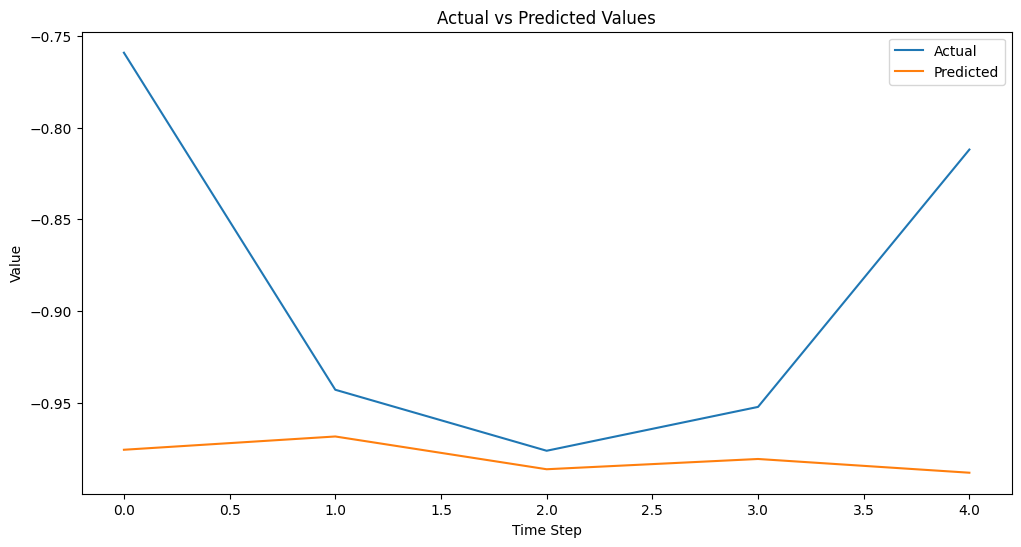

In [ ]:
# Evaluate the model
cnn.eval()
predictions, actuals = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.transpose(1, 2).contiguous()
        outputs = cnn(X_batch)[0]
        predictions.append(outputs.numpy())
        actuals.append(y_batch.numpy())

predictions = np.vstack(predictions)
actuals = np.vstack(actuals)

# Inverse transform the predictions and actual values
predictions = scaler.inverse_transform(predictions)
actuals = actuals.squeeze(-1)
actuals = scaler.inverse_transform(actuals)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f'Test RMSE: {rmse:.4f}')

# Plot the actual vs predicted values for the first test sample
plt.figure(figsize=(12, 6))
# plt.plot(range(len(actuals[11000])), actuals[0], label='Actual')
# plt.plot(range(len(predictions[11000])), predictions[0], label='Predicted')

plt.plot(range(len(actuals)), actuals, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted')

plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()